In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-01",end="2024-02-25").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


Text(0.5, 1.0, 'Closing Price')

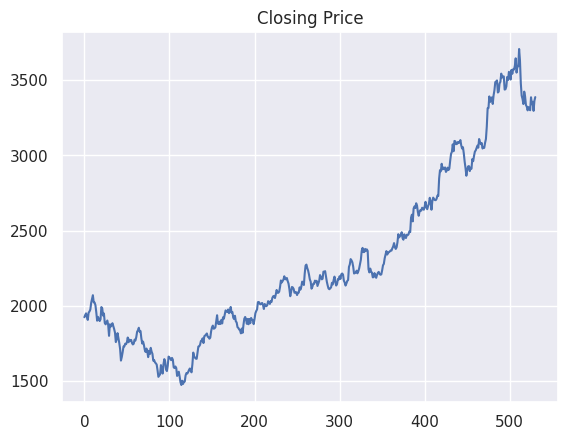

In [ ]:
df_full['Close'].plot()
plt.title('Closing Price')

In [ ]:
from collections import deque
import random
import tensorflow.compat.v1 as tf

df= df_full.copy()
name = 'Double Duel Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, output_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()

    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()

                action = self._select_action(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)

                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)

                cost, _ = self.sess.run([self.model.cost, self.model.optimizer],
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 16
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

<ipython-input-58-af02fbdff8e8>:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
<ipython-input-58-af02fbdff8e8>:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_action = tf.layers.dense(tensor_action, output_size)
<ipython-input-58-af02fbdff8e8>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_validation = tf.layers.dense(tensor_validation, 1)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An i

epoch: 20, total rewards: 2114.650757.3, cost: 1.873734, total money: 12114.650757
epoch: 40, total rewards: 974.950928.3, cost: 0.909184, total money: 7678.551025
epoch: 60, total rewards: -210.200439.3, cost: 0.513278, total money: 6493.399658
epoch: 80, total rewards: 3615.901001.3, cost: 3.946005, total money: 315.700806
epoch: 100, total rewards: 1151.650146.3, cost: 13.806314, total money: 1168.950195
epoch: 120, total rewards: 427.700317.3, cost: 2.797144, total money: 7063.950317
epoch: 140, total rewards: 929.199341.3, cost: 0.486168, total money: 4295.649292
epoch: 160, total rewards: 2438.948364.3, cost: 0.454038, total money: 2348.598267
epoch: 180, total rewards: 420.750244.3, cost: 0.910591, total money: 7064.000244
epoch: 200, total rewards: 1362.999634.3, cost: 0.858904, total money: 11362.999634
epoch: 220, total rewards: 941.550781.3, cost: 0.722471, total money: 10941.550781
epoch: 240, total rewards: 1115.100342.3, cost: 0.106144, total money: 11115.100342
epoch: 26

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 1961.150024, total balance 8038.849976
day 7, sell 1 unit at price 1974.199951, investment 0.665422 %, total balance 10013.049927,
day 15: buy 1 unit at price 1899.900024, total balance 8113.149902
day 16, sell 1 unit at price 1925.300049, investment 1.336914 %, total balance 10038.449951,
day 20: buy 1 unit at price 1990.500000, total balance 8047.949951
day 21, sell 1 unit at price 1982.699951, investment -0.391864 %, total balance 10030.649902,
day 64: buy 1 unit at price 1852.800049, total balance 8177.849854
day 65, sell 1 unit at price 1826.300049, investment -1.430268 %, total balance 10004.149902,
day 75: buy 1 unit at price 1657.349976, total balance 8346.799927
day 76, sell 1 unit at price 1699.949951, investment 2.570367 %, total balance 10046.749878,
day 138: buy 1 unit at price 1767.750000, total balance 8278.999878
day 139, sell 1 unit at price 1782.449951, investment 0.831563 %, total balance 10061.449829,
day 147: buy 1 unit at price 1780.0999

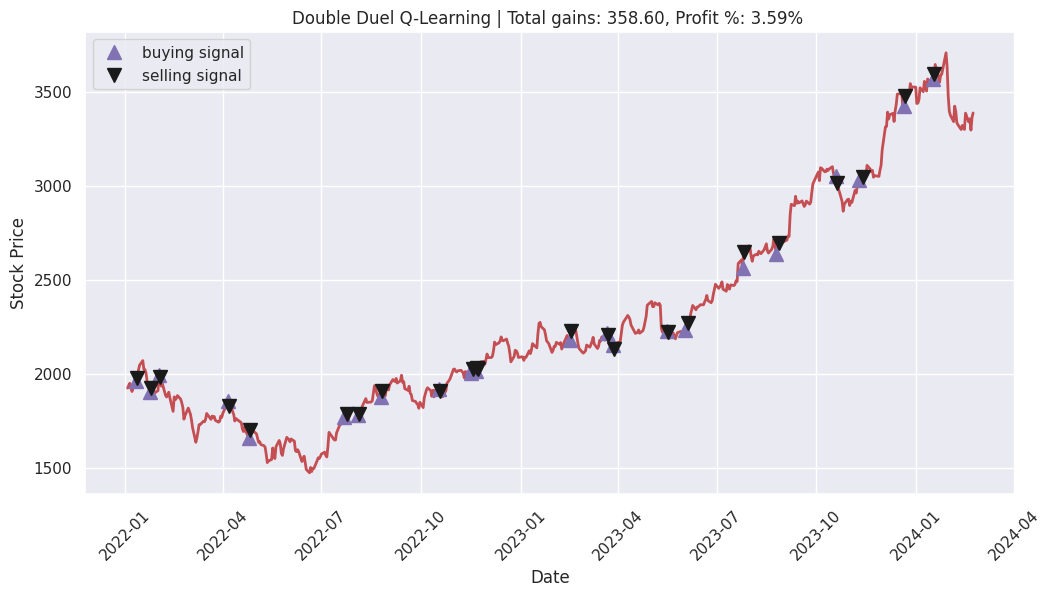

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=10, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=10, color='k', label='selling signal')

plt.title('Double Duel Q-Learning | Total gains: %.2f, Profit %%: %.2f%% '% (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
#Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = close_prices[-1] - close_prices[0]

    # Calculate ROI based on initial investment
    ROI_initial_investment = (total_gains / initial_money) * 100

    # Calculate ROI based on total transactions
    total_investment = initial_money
    for buy_index in states_buy:
        total_investment -= close_prices[buy_index]
    for sell_index in states_sell:
        total_investment += close_prices[sell_index]
    ROI_total_investment = ((close_prices[-1] - total_investment) / total_investment) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

#Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df['Close'].values
total_gains, ROI_initial_investment, ROI_total_investment, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

#Print performance metrics
print("Moving Average Performance Metrics:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI) based on initial investment: {:.2f}%".format(ROI_initial_investment))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))

Moving Average Performance Metrics:
Total Gains: 1465.10
Return on Investment (ROI) based on initial investment: 14.65%
Sharpe Ratio: 1.30
Maximum Drawdown: 16.12%
Winning Trades Percentage: 50.00%
Average Return per Trade: 31.85
Average Holding Period: 1.17


In [ ]:
import numpy as np

def sharpe_ratio(returns, risk_free_rate=0):
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe = (avg_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return sharpe

# Example usage:
if __name__ == "__main__":
    # Example returns data (replace with your own data)
    returns_data = np.random.normal(0.001, 0.02, 100)  # Generating random returns data for demonstration
    risk_free_rate = 0.02  # Assumed annual risk-free rate
    # Calculate Sharpe Ratio
    sharpe = sharpe_ratio(returns_data, risk_free_rate)
    print("Sharpe Ratio:", sharpe)

Sharpe Ratio: -0.810712747026268
